In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

2021-10-05 12:22:31.184220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-05 12:22:31.184299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


In [5]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [6]:
#Normalize data with z-score::
# Calculate the Z-scores of each column in the training set:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")


Normalized the values.


In [7]:

feature_columns = []

resolution_in_Zs  = 0.3
latitude_as_a_numeric_column  = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int (min(train_df_norm["latitude"])),int(max(train_df_norm["latitude"])),resolution_in_Zs))
# bucketizing 
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)


longitude_as_a_numeric_column  = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int (min(train_df_norm["longitude"])),int(max(train_df_norm["longitude"])),resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column,longitude_boundaries)

#creating feature cross
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

population = tf.feature_column.numeric_column("population")

feature_columns.append(population)

#convert the list of feature columns into a layer that will later be fed to the model

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)



In [10]:
#Build a linear regression model
# and plot curve

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [8]:
#create model and train model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model 
  
def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")


Defined the create_model and train_model functions.


Epoch 1/15
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 0s 2ms/step - loss: 0.9511 - mean_squared_error: 0.9511
Epoch 2/15
17/17 [==============================] - 0s 2ms/step - loss: 0.6481 - mean_squared_error: 0.6481
Epoch 3/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4914 - mean_squared_error: 0.4914
Epoch 4/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4088 - mean_squared_error: 0.4088
Epoch 5/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3753 - mean_squared_error: 0.3753
Epoch 6/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3651 - mean_squared_error: 0.3651
Epoch 7/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3619 - mean_squared_error: 0.3619
Epoch 8/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3608 - mean_squared_error: 0.3608
Epoch 9/15
17/17 [========

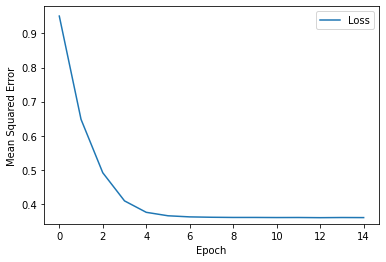


 the linear regression model against the test set
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 2ms/step - loss: 0.3953 - mean_squared_error: 0.3953


[0.3952710032463074, 0.3952710032463074]

In [11]:
#invoking them

learnin_rate = 0.01
epochs = 15

batch_size = 1000
label_name = "median_house_value"

#establishing the topography
my_model  = create_model(learnin_rate, my_feature_layer)

epochs, mse =  train_model(my_model, train_df_norm, epochs, batch_size,label_name)

plot_the_loss_curve(epochs, mse)

test_features = {name: np.array(value) for name, value in test_df_norm.items()}

test_label = np.array(test_features.pop(label_name)) #isolate the label

print("\n the linear regression model against the test set")

my_model.evaluate(x = test_features, y = test_label, batch_size= batch_size)


In [42]:
#defining a deep neural net model
def create_model_2(my_learning_rate, my_feature_layer):
    
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)

    #defining the first hidden layer with 10 nodes

    model.add(tf.keras.layers.Dense(units=10, activation='relu',name = "Hidden1",kernel_regularizer=tf.keras.regularizers.L1(l = 0.01)))

    #hidden layer 2 with 6 nodes
    model.add(tf.keras.layers.Dense(units=6, activation='relu', name="Hidden2",kernel_regularizer=tf.keras.regularizers.L1(l = 0.01)))
    
        #hidden layer 3 with 12 nodes

    model.add(tf.keras.layers.Dense(units=12, activation='relu', name="Hidden3",kernel_regularizer=tf.keras.regularizers.L1(l = 0.01)))

    #output layer
    model.add(tf.keras.layers.Dense(units=1, name="Output"))

    # now compile it
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= my_learning_rate),
    loss = "mean_squared_error", 
    metrics = [tf.keras.metrics.MeanSquaredError()])
    
    return model
    

In [43]:
#Now train that layered model

def train_model_2(my_model, dataset, epochs, label_name, batch_size = None):
    
    #training the model by feeding data. rest is upto TensorFlow

    features = {name: np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))

    history = my_model.fit(x = features, y = label, batch_size = batch_size, 
    epochs = epochs, shuffle = True)

    epochs = history.epoch

    hist = pd.DataFrame(history.history)

    mse = hist["mean_squared_error"]

    return epochs, mse


Epoch 1/1000
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 0s 3ms/step - loss: 1.8086 - mean_squared_error: 0.8692
Epoch 2/1000
17/17 [==============================] - 0s 3ms/step - loss: 0.9154 - mean_squared_error: 0.5596
Epoch 3/1000
17/17 [==============================] - 0s 3ms/step - loss: 0.6742 - mean_squared_error: 0.4699
Epoch 4/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.5731 - mean_squared_error: 0.4272
Epoch 5/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.5337 - mean_squared_error: 0.4028
Epoch 6/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.5091 - mean_squared_error: 0.3889
Epoch 7/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.4916 - mean_squared_error: 0.3793
Epoch 8/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.4784 - mean_squared_error: 0.3737
Epoch 9/10

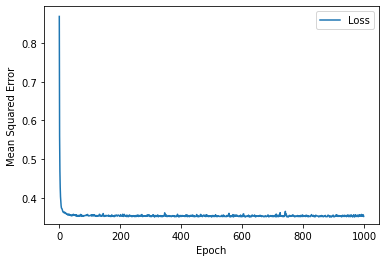


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 2ms/step - loss: 0.4318 - mean_squared_error: 0.3828


[0.4317958950996399, 0.3828102648258209]

In [45]:
#invoke them now
learning_rate = 0.01
epochs = 1000
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model_2(learning_rate, my_feature_layer)

epochs, mse = train_model_2(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)


test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)